In [1]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

from src.core import * 
from src.models import IsotropicGaussian

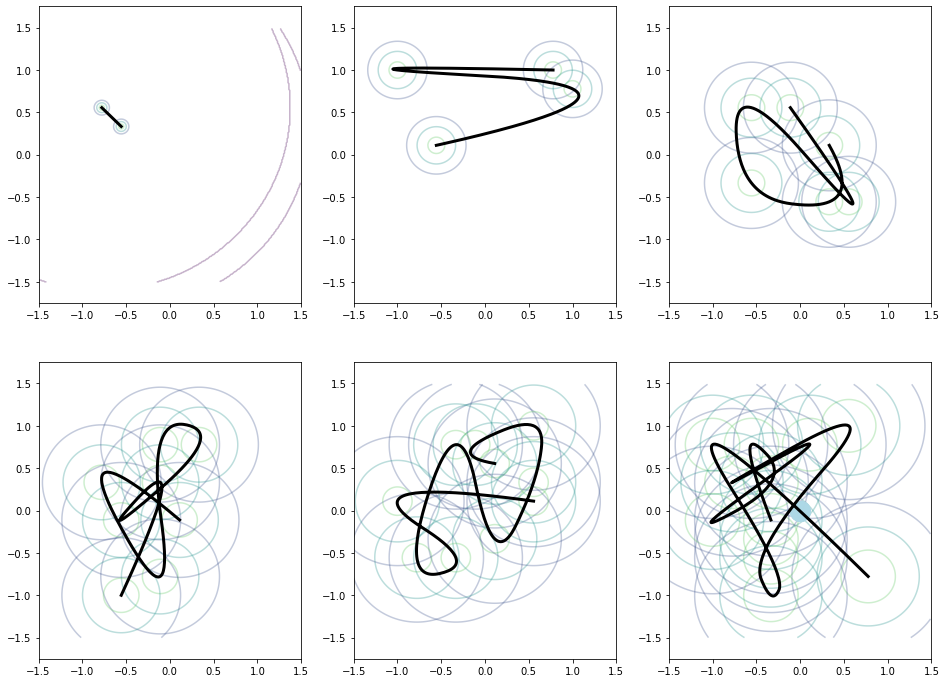

In [2]:
fig, ax = plt.subplots(figsize=(16,12), ncols=3, nrows=2)

grid = make_knot_grid(10, -1, 1)
knot_number = [2, 4, 6, 8, 10, 12]
sigmas, stimuli, models = [],[],[]
for i,nk in enumerate(knot_number):
    k = sample_knots(grid, nk)
    capacity, tau = 11, 7
    model = IsotropicGaussian(k, capacity, tau)
    model.visualize(ax[i//3][i%3])
    sigmas.append(model.sigma[0][0])
    stimuli.append(k)
    models.append(model)
    
plt.show()

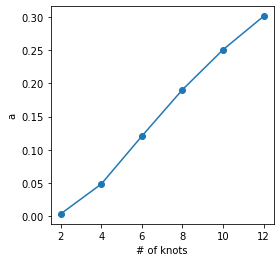

In [3]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(2*np.arange(0, 6) + 2, sigmas)
ax.scatter(2*np.arange(0, 6) + 2, sigmas)
ax.set_xlabel('# of knots')
ax.set_ylabel('a')
plt.show()

In [4]:
s = 1
Hz = 1/s
ms = 1e-3 * s

def homogeneous_poisson(rate, tmax, bin_size):
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    spikes = np.random.rand(nbins) < prob_of_spike
    return spikes * 1

def homogeneous_poisson_generator(n_trials, rate, tmax, bin_size):
    for i in range(n_trials):
        yield homogeneous_poisson(rate, tmax, bin_size)
        
def generate_rf_grid(n, low, high):
    step = (high-low) / (n)
    start = low + step
    stop = high 
    grid = []
    for x in np.linspace(low, high, num=n+2)[1:-1]:
        for y in np.linspace(low, high, num=n+2)[1:-1]:
            grid.append([x, y])   
    return np.array(grid)

def gaussian_rf(x, y, strength, spread):
    dist = np.linalg.norm(x-y)
    return strength * np.exp(-(dist)**2 / (2*(spread**2)))

def encoder(stimuli, rf_grid, strength=1, spread=.1, noise_rate=.1, scale=10):
    signal = np.zeros(len(rf_grid))
    for stim in stimuli:
        signal += np.array([gaussian_rf(rf_loc, stim, strength, spread) for rf_loc in rf_grid])
    noise = np.ones(len(signal)) * noise_rate
    lam = signal + noise
    lam /= lam.sum() # normalize
    return lam * scale

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance),2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=.05)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=.05)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [5]:
sid = 2

rf_res = 35
strength = 35
spread = .2
noise_rate = 15
scale = 150
bin_size = 1 * ms # bin size 
tmax = 5 * s      # the total length of the spike train

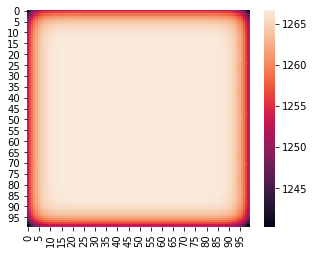

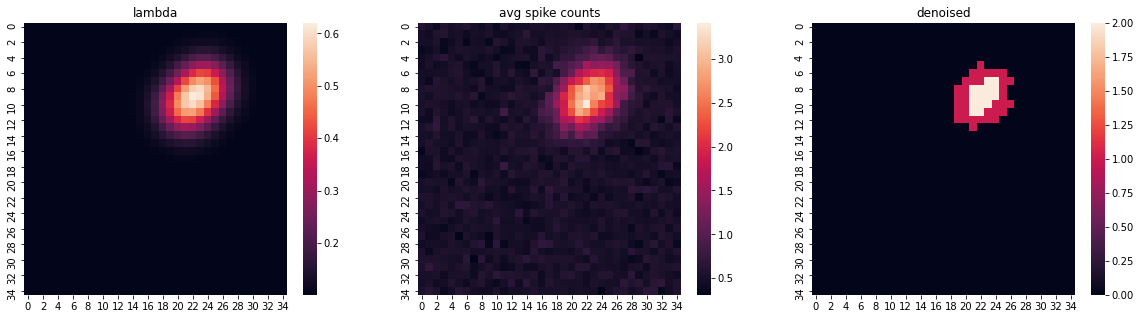

In [6]:
sid = 0

rf_res = 35
strength = 35
spread = .2
noise_rate = 10
scale = 150
bin_size = 1 * ms # bin size 
tmax = 5 * s      # the total length of the spike train

X = np.zeros((100, 100, 2))
for i,x in enumerate(np.linspace(-1, 1, 100)):
    for j,y in enumerate(np.linspace(-1, 1, 100)):
        X[i, j, 0] =  x
        X[i, j, 1] = y

low, high = -1.5, 1.5
rf_grid = generate_rf_grid(rf_res, low, high)

field = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        activation = np.array([gaussian_rf(X[i,j], y, strength, spread) for y in rf_grid])
        field[i][j] = activation.sum()
    
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(field, ax=ax)

plt.show()

stim = stimuli[sid]
lam = encoder(stim, rf_grid, strength=strength, spread=spread, noise_rate=noise_rate, scale=scale)

avg_spikes = np.zeros(len(lam))
for i,rate in enumerate(lam):
    n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
    avg_spikes[i] = np.mean(n_spikes)

avg_spikes_rounded = avg_spikes.astype('int')
avg_spikes_rounded = (avg_spikes - np.median(avg_spikes)).astype('int')
avg_spikes_rounded[avg_spikes_rounded < 0] = 0


fig, ax = plt.subplots(figsize=(20,5), ncols=3)
s = int(np.sqrt(len(lam)))
sns.heatmap(np.reshape(lam, (s,s)), ax=ax[0])
sns.heatmap(np.reshape(avg_spikes, (s,s)), ax=ax[1])
sns.heatmap(np.reshape(avg_spikes_rounded, (s,s)), ax=ax[2])


ax[0].set_title('lambda')
ax[1].set_title('avg spike counts')
ax[2].set_title('denoised')

plt.show()

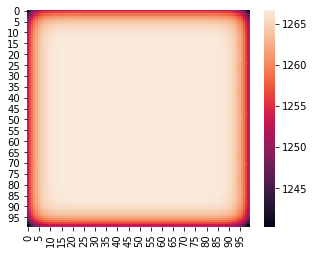

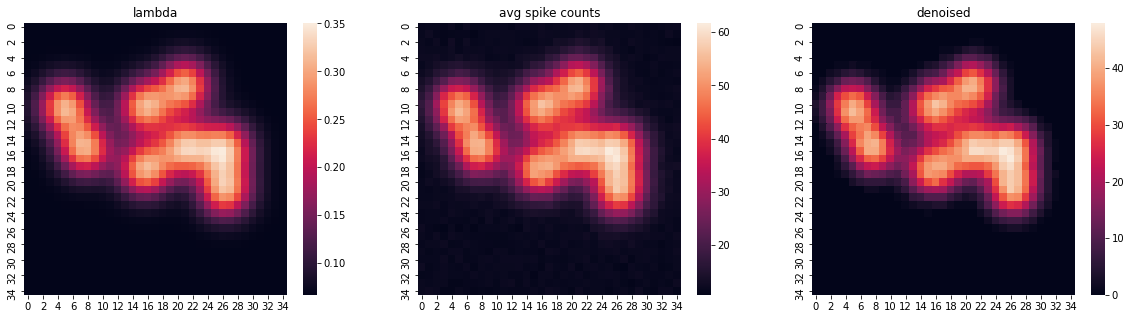

In [14]:
sid = 3

rf_res = 35
strength = 35
spread = .2
noise_rate = 10
scale = 150
bin_size = 1 * ms # bin size 
tmax = 5 * s      # the total length of the spike train

X = np.zeros((100, 100, 2))
for i,x in enumerate(np.linspace(-1, 1, 100)):
    for j,y in enumerate(np.linspace(-1, 1, 100)):
        X[i, j, 0] =  x
        X[i, j, 1] = y

low, high = -1.5, 1.5
rf_grid = generate_rf_grid(rf_res, low, high)

field = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        activation = np.array([gaussian_rf(X[i,j], y, strength, spread) for y in rf_grid])
        field[i][j] = activation.sum()
    
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(field, ax=ax)

plt.show()

stim = stimuli[sid]
lam = encoder(stim, rf_grid, strength=strength, spread=spread, noise_rate=noise_rate, scale=scale)

avg_spikes = np.zeros(len(lam))
for i,rate in enumerate(lam):
    n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
    avg_spikes[i] = np.mean(n_spikes)

avg_spikes_rounded = avg_spikes.astype('int')
avg_spikes_rounded = (avg_spikes - np.median(avg_spikes)).astype('int')
avg_spikes_rounded[avg_spikes_rounded < 0] = 0


fig, ax = plt.subplots(figsize=(20,5), ncols=3)
s = int(np.sqrt(len(lam)))
sns.heatmap(np.reshape(lam, (s,s)), ax=ax[0])
sns.heatmap(np.reshape(avg_spikes, (s,s)), ax=ax[1])
sns.heatmap(np.reshape(avg_spikes_rounded, (s,s)), ax=ax[2])


ax[0].set_title('lambda')
ax[1].set_title('avg spike counts')
ax[2].set_title('denoised')

plt.show()

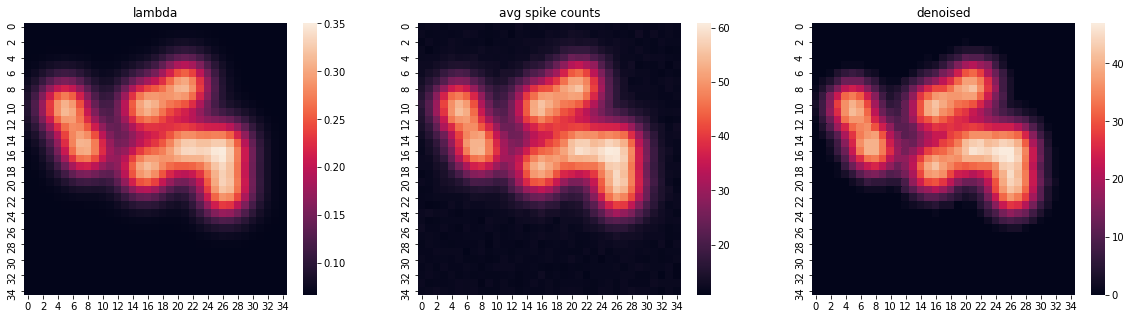

In [15]:
stim = stimuli[sid]
lam = encoder(stim, rf_grid, strength=strength, spread=spread, noise_rate=noise_rate, scale=scale)

avg_spikes = np.zeros(len(lam))
for i,rate in enumerate(lam):
    n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
    avg_spikes[i] = np.mean(n_spikes)

avg_spikes_rounded = avg_spikes.astype('int')
avg_spikes_rounded = (avg_spikes - np.median(avg_spikes)).astype('int')
avg_spikes_rounded[avg_spikes_rounded < 0] = 0


fig, ax = plt.subplots(figsize=(20,5), ncols=3)
s = int(np.sqrt(len(lam)))
sns.heatmap(np.reshape(lam, (s,s)), ax=ax[0])
sns.heatmap(np.reshape(avg_spikes, (s,s)), ax=ax[1])
sns.heatmap(np.reshape(avg_spikes_rounded, (s,s)), ax=ax[2])


ax[0].set_title('lambda')
ax[1].set_title('avg spike counts')
ax[2].set_title('denoised')

plt.show()

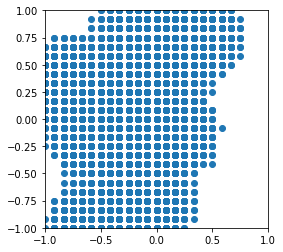

In [16]:
obs = np.ones((int(avg_spikes_rounded.sum()), 2))
count = 0
for xy, n in zip(rf_grid, avg_spikes_rounded):
    for _ in range(n):
        obs[count] = xy
        count +=1

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(obs[:,0], obs[:,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

plt.show()

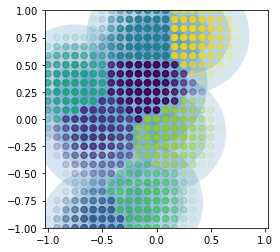

In [17]:
gmm = GaussianMixture(n_components=len(stim), covariance_type='spherical').fit(obs)

fig, ax = plt.subplots(figsize=(4, 4))
plot_gmm(gmm, obs, ax=ax)


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.show()

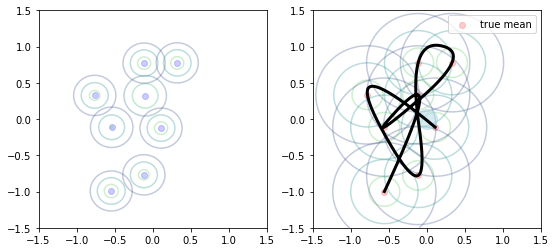

In [18]:
from scipy.stats import multivariate_normal

fig, ax = plt.subplots(figsize=(9,4), ncols=2)


ax[0].scatter(gmm.means_[:,0], gmm.means_[:,1], c='blue', alpha=.2, label='estimated mean')
ax[1].scatter(stim[:,0], stim[:,1], c='red', alpha=.2, label='true mean')

models[sid].visualize(ax[1])

x, y = np.mgrid[-1.5:1.5:.01, -1.5:1.5:.01]
data = np.dstack((x, y))
for mu, a in zip(gmm.means_, gmm.covariances_):
    sigma = np.array([[a, 0],[0, a]])
    rv = multivariate_normal(mu, sigma)
    z = rv.pdf(data)
    ax[0].contour(x, y, z, 3, alpha=.3)

for i in [0, 1]:
    ax[i].set_xlim((-1.5, 1.5))
    ax[i].set_ylim((-1.5, 1.5))

plt.legend()
plt.show()

In [12]:
covs = []
for stim in tqdm(stimuli):
    lam = encoder(stim, rf_grid, strength=strength, spread=spread, noise_rate=noise_rate, scale=scale)
    avg_spikes = np.zeros(len(lam))
    for i,rate in enumerate(lam):
        n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
        avg_spikes[i] = np.mean(n_spikes)
    avg_spikes_rounded = avg_spikes.astype('int')
    #print(avg_spikes_rounded.sum())
    obs = np.ones((int(avg_spikes_rounded.sum()), 2))
    count = 0
    for xy, n in zip(rf_grid, avg_spikes_rounded):
        for _ in range(n):
            obs[count] = xy
            count +=1
    gmm = GaussianMixture(n_components=len(stim), covariance_type='spherical').fit(obs)
    covs.append(gmm.covariances_)

  0%|          | 0/6 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/naxos2-raid26/joh18320/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-7edc200b8185>", line 6, in <module>
    n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
  File "<ipython-input-12-7edc200b8185>", line 6, in <listcomp>
    n_spikes = [np.sum(sp) for sp in homogeneous_poisson_generator(100, rate, tmax, bin_size)]
  File "<ipython-input-4-5eda4f09dbc0>", line 13, in homogeneous_poisson_generator
    yield homogeneous_poisson(rate, tmax, bin_size)
  File "<ipython-input-4-5eda4f09dbc0>", line 8, in homogeneous_poisson
    spikes = np.random.rand(nbins) < prob_of_spike
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/naxos2-raid26/joh18320/anaconda3/lib/python3.8/site-packages/IPytho

TypeError: object of type 'NoneType' has no len()